# Tutorial: Simulating a Pendulum and Mock Data

# 0. Setup and Versions

Your versions do not have to be exactly the same, this is just included for reference

In [2]:
import sys
print(f"Python version: {sys.version}")

Python version: 3.10.4 | packaged by conda-forge | (main, Mar 30 2022, 08:38:02) [MSC v.1916 64 bit (AMD64)]


In [3]:
from importlib.metadata import version

for module in ['numpy','matplotlib','scipy', 'ipywidgets']:
    print(module + ': ' + version(module))

numpy: 1.21.5
matplotlib: 3.5.2
scipy: 1.7.3
ipywidgets: 7.6.5


**If the above gives you an error** that you dont have one of the packages, you should uncomment and run the following lines

In [79]:
# 3 quotes can be used for a multiline comment. Note that you likely only need "ipympl" below if using visual studio code
"""
im_using_anaconda = True  # change if youre using python virtual envs or something other than anaconda to manage environments

if im_using_anaconda:
    # The ! executes the following text in the command line, and uses the same environment that your notebook is running in
    !conda install --yes numpy scipy matplotlib ipywidgets ipympl
else:
    !yes | pip install numpy scipy matplotlib ipywidgets ipympl
"""

# The output saved in this notebook by default (just below) is what happens when you already have those packages installed in anaconda.

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done


# 1. The Pendulum - When we already know g

First we look at the motion of a pendulum under gravity when we assume small oscillations and no friction forces. The diagram below (from [here](https://www.acs.psu.edu/drussell/Demos/Pendulum/Pendulum.html)) sets the notation for the problem. $L$ is the distance from the pivot point to the center of mass, and the total mass of the bob is $m$.

<p align="center">
  <img src="pendulum.jpg" width="22%" height="22%"/>
</p>

The equation of motion is $mL\ddot{\theta} = mg\sin\theta$ which can be rearraged to 
\begin{equation}
\ddot{\theta} = -\frac{g}{L}\sin\theta
\end{equation}

Under the assumption of small oscillations ($\theta \ll 1$), this reduces to 
$$
\ddot{\theta} = -\frac{g}{L}\theta
$$
This equation admits an analytical solution given by

$$\theta(t) = \theta_0 \cos(\omega t)$$

where $\omega = \sqrt{\frac{g}{L}}$ and $\theta_0$ is the angle at $t=0$. This analytical motion can be easily plotted as follows:

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Following local acceleration due to gravity from 
# https://sciencedemonstrations.fas.harvard.edu/presentations/newtons-apple#:~:text=The%20value%20of%20g%20for,is%209.8038%20m%2Fs2.
# But can we trust Harvard ??
g_cambridge = 9.8038  # In SI units [ms^{-2}]

L = 1.0 # In meters [m]


# Code up the analytical solution, we use the numpydoc format for function docstrings (https://numpydoc.readthedocs.io/en/latest/example.html)
def small_angle_theta(t, theta0 = np.pi/8, omega = np.sqrt(g_cambridge/L)):   # we set some reasonable default values
    """ Angular position of a small angle approximation pendulum of frequency omega at time t

        Parameters
        ----------
        t : array_like  (basically means a number, list of numbers or numpy array of numbers, likely floats in this instance)
            time at which we evaluate the position [seconds]
        theta0 : float
            angular position of pendulum at time t=0 [radians]
        omega : float
            frequency of oscillator [radians per second]

        Returns
        -------
        theta : array_like
            angular position of pendulum at time t [radians]
    """ 
    return theta0 * np.cos(omega*t)

Text(0.5, 1.0, 'Motion of small angle pendulum')

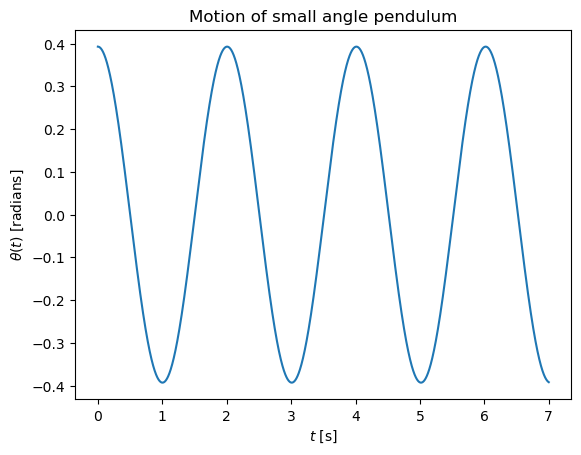

In [5]:
# Make a plot
num_timesteps = 10000

t_values = np.linspace(0, 7, num_timesteps)
small_angle_theta_values = small_angle_theta(t_values)  # numpy operations automatically broadcast calculation over whole array of t values
                                                        # We also use the default values for theta0 and omega

plt.plot(t_values, small_angle_theta_values)
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\theta (t)$ [radians]")
plt.title("Motion of small angle pendulum")

One can see the period of osciallation $T = \frac{2\pi}{\omega}$, and that the amplitude is constant as we havent included any friction forces 

# 2. Without small angle approximation
If we dont make the small angle approximation, we must solve the nonlinear equation of motion (equation 1) numerically. This involves some approximate scheme where one takes the current position $\theta(t)$ and updates it to a value later in time by some small timestep $\theta(t + dt)$ using the nonlinear equation of motion.

The numerical scheme we will use is called "Leapfrog integration" (see [this page](https://en.wikipedia.org/wiki/Leapfrog_integration)) because it is lightweight, stable, and doesnt drift away from the true solution over time, as can occur with methods such as the Runge-Kutta methods. The code below is taken from [this page](http://cvarin.github.io/CSci-Survival-Guide/leapfrog.html) which is a much more detailed introduction to leapfrog integration

### 2.1 Reformulating the problem
The first step is to reformulate our second order differential equation in $\theta$ as two first order differential equations, in $\theta$ and $v :=\dot{\theta}$. From equation 1 above we get
$$
\begin{align}
\frac{d\theta}{dt} &= v\\
\frac{dv}{dt} &= -\frac{g}{L}\sin\theta
\end{align}
$$

which is a coupled pair of first order differential equations in $\theta$ and $v$. Note that since $v$ is just an angular speed [radians per second] to convert it to a rate of change of distancce, one must multiply is by L. so the rate of change of position is $Lv$.

### 2.2 The principle of Leapfrog Integration
The basic principle used by leapfrog integration is that we update one variable at timesteps $t_0,t_1,t_3,\dots$ and the other at the half-timesteps between those values, that is $\frac{t_1 - t_0}{2}, \frac{t_2 - t_1}{2}, \dots$ which we can also label $t_{1/2},t_{3/2},t_{5/2},\dots$. For more details see the link above. In the diagram below (from [here](http://www.physics.drexel.edu/~steve/Courses/Comp_Phys/Integrators/leapfrog/)) "x" respresents our "$\theta$"
<p align="center">
  <img src="leapfrog.jpg" width="40%" height="40%"/>
</p>

Using the definition of the derivative and the first of our coupled equations above, we approximate the updated theta values by the following scheme:

$$
\frac{\theta_{n+1} - \theta_{n}}{dt} = v_{n + 1/2} \quad \implies \quad \theta_{n+1} = \theta_n + dt \,v_{n + 1/2}
$$

And for the updated $v$ values, we use the other of our coupled equations to write

$$
\frac{v_{n+1/2} - v_{n-1/2}}{dt} = -\frac{g}{L}\sin(\theta_n) \quad \implies \quad v_{n+1/2} = v_{n - 1/2} - dt\,\frac{g}{L}\sin(\theta_n)
$$

### 2.3 Python implementation of leapfrog integrator
The integrator below is actually a reasonably general leapfrog integrator, as we pass the only problem-specific information (the RHS of the v equation and any problem-specific arguments) in a general manner. As a result, the integrator can be used for many problems. However in research or any practical application, >99% of people will just use something like the scipy package's "odeint" (see [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)) function or similar. The issue of numerical solutions to ODEs was solved in the 1980s and most subsequent solvers are just interfaces to the same code, for example a python interface to precompiled fortran code.

In [6]:
def v_update_pendulum(theta, v, t, dt, omega=np.sqrt(g_cambridge/L)): # omega is passed to this function by **kwargs below when integrating with the below function
    """ RHS of the v update equation for the unforced, undamped pendulum without the small angle approximation (just above)

        Parameters
        ----------
        theta : float
            angular position of pendulum [radians]
        v : float
            angular speed of pendulum [radians per second]
        t : float
            current value of the time variable [seconds]
        omega : float
            frequency of the small angle approximation oscillator [radians per second]

        Returns
        -------
        v_updated : float
            value of v at next timestep [radians per second]
    """

    # calculate updated v
    v_updated = v - dt * np.power(omega,2) * np.sin(theta)

    return v_updated 

In [7]:
# kwargs is by default an empty dictionary of problem-specific keyword arguments. ** unpacks this dictionary into function arguments in the 
# usual format. If you are uncomfortable with this sort of thing, you can look at https://realpython.com/python-kwargs-and-args/ 
# or just hardcode the parameters of your v update function into the integrator as arguments.

def integrate(v_update_function, t_values, theta0=0, v0=0.0, **kwargs):
    """ Integrate the motion of a pendulum under the influence of gravity without the small angle approximation, using leapfrog integration

        Parameters
        ----------
        v_update_function : function
            function describing the RHS of the v update equation, where v = \dot{theta}
        t : array
            uniformly spaced timesteps at which we want the solution theta(t) and v(t) [seconds]
        theta0 : float
            angular position of pendulum at time t=0 [radians]
        v0 : float
            velocity of pendulum in theta direction at time t=0 [radians per second]
        **kwargs : keyword argument dictionary
            This is the standard python way of passing a list of keyword arguments through a function. 
            Will be passed to v_update_function for its problem-specific arguments.

        Returns
        -------
        theta_values : array_like
            angular position of pendulum at times t [radians]
        v_values : array_like
            angular speed of pendulum at times t [radians per second]
    """
    # Time step information
    N = len(t_values)
    dt = t_values[1] - t_values[0]

    # arrays are allocated and filled with zeros
    theta_values = np.zeros(N)
    v_values = np.zeros(N)

    # initial conditions
    theta_values[0] = theta0
    v_values[0] = v0
    
    # integration via leapfrog method
    for i in range(N-1):
        v_values[i + 1] = v_update_function(theta=theta_values[i], v=v_values[i], t = t_values[i], dt=dt, **kwargs) # the ** unpacks dictionary of problem-specific keyword arguments (kwargs)
        theta_values[i + 1] = theta_values[i] + dt*v_values[i + 1]
    
    # return solution
    return theta_values, v_values

### 2.4 Perform the integration

In [8]:
theta0 = np.pi/5
omega = np.sqrt(g_cambridge/L) # already the default value, but plugging it into the functions for demonstration purposes

theta, v = integrate(v_update_pendulum, t_values=t_values, theta0=theta0, omega=omega) # no small angle approx.
small_angle_theta_values = small_angle_theta(t_values, theta0=theta0, omega=omega) # small angle approx

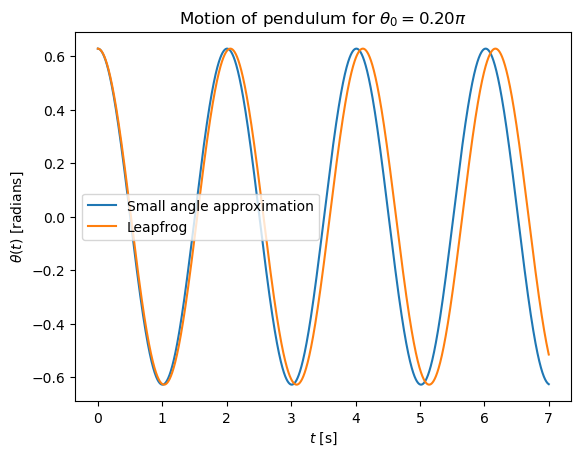

In [9]:
fig = plt.figure()

plt.plot(t_values, small_angle_theta_values, label = "Small angle approximation")
plt.plot(t_values, theta, label = "Leapfrog")
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\theta (t)$ [radians]")
plt.title(r"Motion of pendulum for $\theta_0={:.2f}\pi$".format(theta0/np.pi))
plt.legend()

Now repeat for a large initial angle

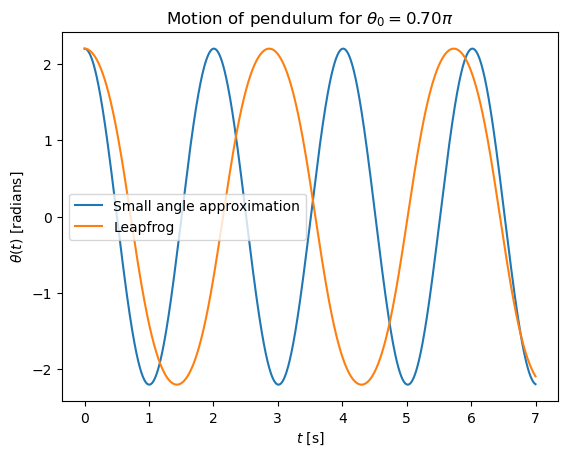

In [10]:
large_theta0 = 0.7*np.pi

small_angle_theta_values = small_angle_theta(t_values, theta0=large_theta0) # use default value for omega
theta, v = integrate(v_update_pendulum, t_values, theta0=large_theta0) # use default value for omega

fig = plt.figure()

plt.plot(t_values, small_angle_theta_values, label = "Small angle approximation")
plt.plot(t_values, theta, label = "Leapfrog")
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\theta (t)$ [radians]")
plt.title(r"Motion of pendulum for $\theta_0={:.2f}\pi$".format(large_theta0/np.pi))
plt.legend()

# 3. Additional forces and friction

An external force $F(\theta,t)$ can be added to our equation of motion Eq. 1 in the following manner:
$$
\ddot{\theta} = -\omega\sin\theta + \frac{F}{mL}
$$
where $m$ is the mass of the pendulum bob. In a similar manner, a friction or "drag" term such as one proportional to velocity can be added additionally in the following manner:
$$
\ddot{\theta} = -\omega\sin\theta + \frac{F}{m} - \gamma\,v
$$
where the proportionality constant for the drag term is $\gamma > 0$ and again $\omega = \frac{g}{L}$. **We assume $\mathbf{L=1}$ in this equation**, or equivalently consider the factors of $1/L$ as absorbed into $\gamma$ and $F$ (similar for factors of $1/m$ absorbed into $\gamma$). Note that if for some reason the velocity-dependent term was positive, it wouldnt be appropriate to refer to it as a "drag" term.

With such an equation of motion, our $v$ update equation is calculated as before to yield:
\begin{equation}
\frac{v_{n+1 / 2}-v_{n-1 / 2}}{d t}=\frac{F(\theta_n,t_n)}{m}-\gamma \frac{v_{n+1 / 2}+v_{n-1 / 2}}{2}-\omega^2 \sin(\theta_n) \\
\end{equation}

\begin{equation}
\implies v_{n+1 / 2}= \frac{\left(1-\frac{\gamma \,d t}{2}\right)}{\left(1+\frac{\gamma \,d t}{2}\right)} v_{n-1 / 2}+\frac{d t}{m\left(1+\frac{\gamma\, d t}{2}\right)} F(\theta_n,t_n)-\frac{\omega^2 \,dt}{\left(1+\frac{\gamma\, dt}{2}\right)} \sin(\theta_n)
\end{equation}

### 3.1 A damped oscillator 
For the moment, lets **ignore the external forcing** (so $F=0$) Lets now implement this update equation in python


In [11]:
def v_update_pendulum_drag(theta, v, t, dt, omega=np.sqrt(g_cambridge/L), gamma=0):
    """ RHS of the v update equation for the unforced pendulum with drag force and without the small angle approximation

        Parameters
        ----------
        theta : float
            angular position of pendulum [radians]
        v : float
            angular speed of pendulum [radians per second]
        t : float
            current value of the time variable [seconds]
        omega : float
            frequency of the small angle approximation oscillator [radians per second]
        gamma : float
            proportionality constant of the drag force [s^{-1} here, but depends what factors you absorb into gamma]

        Returns
        -------
        v_updated : float
            value of v at next timestep [radians per second]
    """

    fac1 = 1.0 - 0.5*gamma*dt
    fac2 = 1.0/(1.0 + 0.5*gamma*dt)

    # calculate updated v   
    v_updated = fac1*fac2*v - fac2 *dt * np.power(omega,2) * np.sin(theta)

    return v_updated 

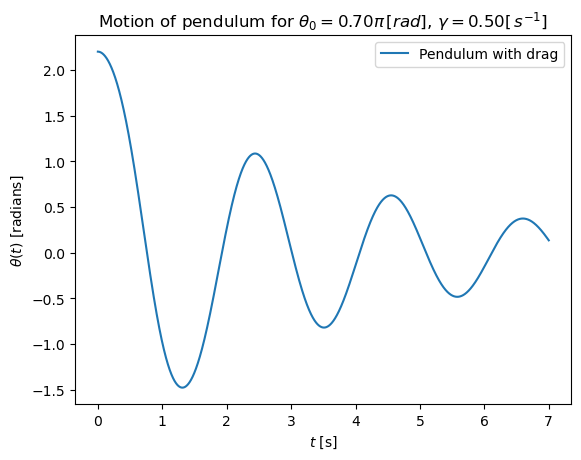

In [12]:
large_theta0 = 0.7*np.pi
gamma=0.5

theta_drag, v_drag = integrate(v_update_pendulum_drag, t_values, theta0=large_theta0, gamma=gamma)

fig = plt.figure()

plt.plot(t_values, theta_drag, label = "Pendulum with drag")
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\theta (t)$ [radians]")
plt.title(r"Motion of pendulum for $\theta_0={:.2f}\pi \,[rad]$, $\gamma={:.2f}$".format(large_theta0/np.pi,gamma) + r"[$\,s^{-1}$]")
plt.legend()

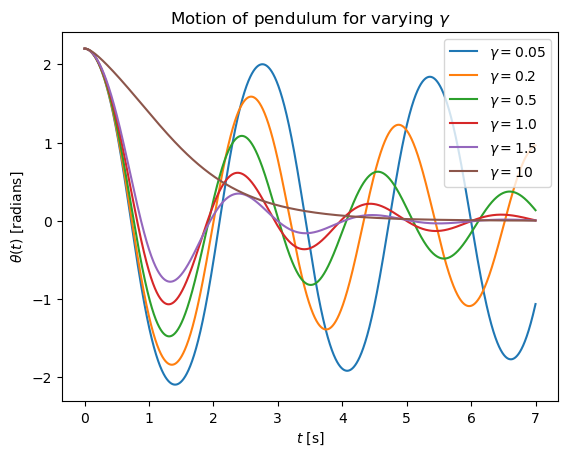

In [13]:
# investigate how drag coefficient changes times of maximum anglular displacement

gamma_list = [0.05, 0.2, 0.5, 1.0, 1.5, 10]

fig = plt.figure()

for gamma in gamma_list:
    theta_drag, v_drag = integrate(v_update_pendulum_drag, t_values, theta0=large_theta0, gamma=gamma)

    plt.plot(t_values, theta_drag, label = r"$\gamma=$" + f"{gamma}")

plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\theta (t)$ [radians]")
plt.title(r"Motion of pendulum for varying $\gamma$")
plt.legend()

Evidently, as $\gamma$ increases, it tends to drive up the apparent frequency of oscillation while simultaneously reducing the amplitude of oscillation. However by increasing the drag enough, we damp oscillations away entirely (imagine the bob moving through a highly viscous fluid instead of air)

### 3.2 (optional) Adding forcing

Say we add a position-independent force $F = \sin(\omega_F\,t)$ (maybe a charged bob in a uniform oscillating field or something). We would implement this as follows:

In [14]:
def v_update_pendulum_drag_forced(theta, v, t, dt, omega=np.sqrt(g_cambridge/L), gamma=0, F=(lambda x,y:0.0), m=1.0):
    """ RHS of the v update equation for the unforced pendulum with drag force and without the small angle approximation

        Parameters
        ----------
        theta : float
            angular position of pendulum [radians]
        v : float
            angular speed of pendulum [radians per second]
        t : float
            current value of the time variable [seconds]
        omega : float
            frequency of the small angle approximation oscillator [radians per second]
        gamma : float
            proportionality constant of the drag force [s^{-1}]
        F : function, two arguments (theta, t), defalt returns zero
            External (non-gravity) force which can be dependent on position and time
        m : float
            mass of pendulum [kg]

        Returns
        -------
        v_updated : float
            value of v at next timestep [radians per second]
    """

    fac1 = 1.0 - 0.5*gamma*dt
    fac2 = 1.0/(1.0 + 0.5*gamma*dt)

    # calculate updated v
    v_updated = fac1*fac2*v - fac2 *dt * np.power(omega,2) * np.sin(theta)  + fac2*dt*F(theta, t)/m
    
    return v_updated 

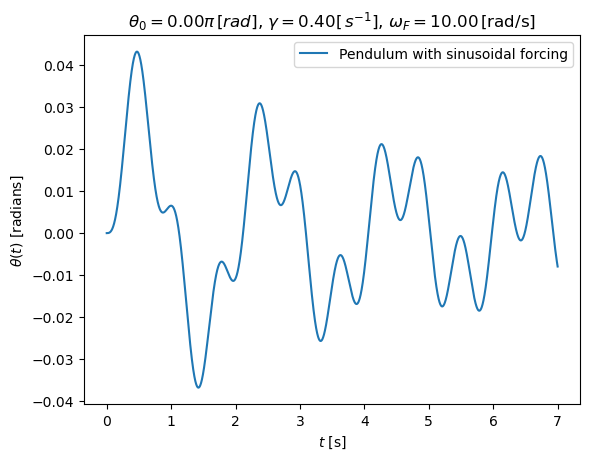

In [15]:
# Define external force
omegaF = 10

def external_F(theta,t):
    return np.sin(omegaF*t)

# Integrate
small_theta0 = 0.0
gamma=0.4

theta_forced, v_forced = integrate(v_update_pendulum_drag_forced, t_values, theta0=small_theta0, gamma=gamma, F=external_F)

fig = plt.figure()

plt.plot(t_values, theta_forced, label = "Pendulum with sinusoidal forcing")
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\theta (t)$ [radians]")
plt.title(r"$\theta_0={:.2f}\pi \,[rad]$, $\gamma={:.2f}$".format(small_theta0/np.pi,gamma) + r"[$\,s^{-1}$]" + r", $\omega_F={:.2f}\,$[rad/s]".format(omegaF))
plt.legend()

In the above, we can see both the frequency of the oscillatior under gravity and the driving force frequency present in the motion. If we turned off drag, we could do a Fourier decomposition of the data and recover both the frequency we obtained above before adding forcing, and the driving force frequency.

# 4. What would real data following this equation of motion look like?

If we had a pendulum that perfectly followed the equation 
$$
\ddot{\theta} = -\omega\sin\theta + \gamma\,v
$$
that is a damped, unforced pendulum, and we attempted to measure the position of the bob over time, what would the data look like?

Lets say that our $2\sigma$ measurement error is simply 0.2 radians always (meaning we are about 95% confident we'll measure a value no more than 0.2 radians off), then our measurements could fall anywhere within the light blue band in the plot below. We also plot some example expermental data which could be measured from such a "true motion", where we also add some errors in the measurement of the time parameter to mimic the process of taking real data.

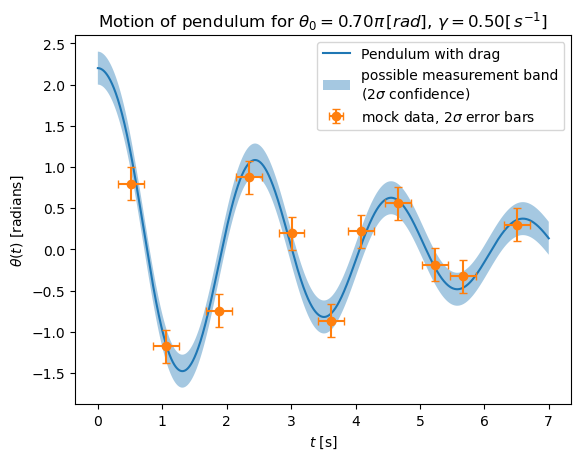

In [16]:
theta_measurement_error = 0.2 # 2sigma (95% confidence) error on theta measurements[radians] 
t_measurement_error = 0.2 # 2sigma (95% confidence) error on t measurements [s]

large_theta0 = 0.7*np.pi
gamma=0.5

theta_drag_error, v_drag_error = integrate(v_update_pendulum_drag, t_values, theta0=large_theta0, gamma=gamma) 
# (could also have used v_update_pendulum_drag_forced since the default F is zero.)

# Mock data
N = int(num_timesteps/12)

mock_data = theta_drag_error[N:-N:N].copy() # take every Nth value in the dense, integrated curve, starting at the Nth element and finishing N elements before the end
                                     # format is start:stop:stepsize and we could have well done ::N, which by default means start at the start and finish at the end
                                     # .copy() is necessary just because otherwise we would create a "view" https://numpy.org/doc/stable/user/basics.copies.html
mock_data += np.random.normal(0.0, theta_measurement_error/2, size=len(mock_data))    # add Gaussian noise according to theta_measurement_error, 
                                                                # recall we defined theta_measuement_error as the 2sigma error, so divide by 2

mock_data_times = t_values[N:-N:N].copy()
mock_data_times += np.random.normal(0.0, t_measurement_error/2, size=len(mock_data_times))


# plot
fig = plt.figure()

plt.plot(t_values, theta_drag_error, label = "Pendulum with drag")
plt.fill_between(t_values, theta_drag_error - theta_measurement_error, theta_drag_error + theta_measurement_error,
                alpha=0.4, 
                label="possible measurement band\n($2\sigma$ confidence)"
                )

plt.errorbar(mock_data_times, mock_data, yerr=theta_measurement_error, xerr=t_measurement_error,
            fmt="o", capsize=3, label=r"mock data, $2\sigma$ error bars")

plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\theta (t)$ [radians]")
plt.title(r"Motion of pendulum for $\theta_0={:.2f}\pi \,[rad]$, $\gamma={:.2f}$".format(large_theta0/np.pi,gamma) + r"[$\,s^{-1}$]")
plt.legend()

It may be the case that the measurement error is velocity-dependent (at least if measuring by eye or with a camera of finite framerate). In this case, lets say the error is 0.2 radians, modulated by the velocity in such a way that when the pendulum is going quickly, we are less certain where it is at a particular moment.

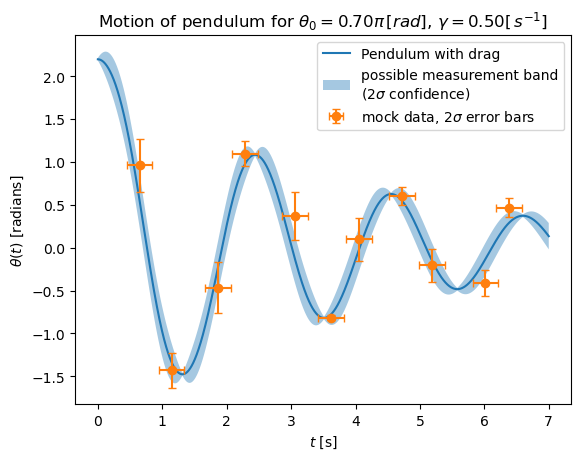

In [17]:
theta_measurement_error = 0.3
modulation = np.tanh(0.5*np.abs(v_drag_error)) + 0.05 # means error is about 0.3 radians when going very fast, 0.05 radians when not moving

lower_bound = theta_drag_error - theta_measurement_error * modulation
upper_bound = theta_drag_error + theta_measurement_error * modulation


# Mock data
N = int(num_timesteps/12)

errors_2sigma = ((upper_bound - lower_bound)/2)[N:-N:N].copy() # half of the full width is roughly the size of the error (which we defined to be 2sigma)

mock_data = theta_drag_error[N:-N:N].copy() 
mock_data += np.random.normal(0.0, errors_2sigma/2, size=len(mock_data))    # add Gaussian noise according to theta_measurement_error, 
                                                                # recall we defined theta_measuement_error as the 2sigma error, so divide by 2

mock_data_times = t_values[N:-N:N].copy()
mock_data_times += np.random.normal(0.0, t_measurement_error/2, size=len(mock_data_times))


# plot
plt.plot(t_values, theta_drag_error, label = "Pendulum with drag")
plt.fill_between(t_values, lower_bound, upper_bound, alpha=0.4, 
                label="possible measurement band\n($2\sigma$ confidence)")

plt.errorbar(mock_data_times, mock_data, yerr=errors_2sigma, xerr=t_measurement_error,
            fmt="o", capsize=3, label=r"mock data, $2\sigma$ error bars")

plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\theta (t)$ [radians]")
plt.title(r"Motion of pendulum for $\theta_0={:.2f}\pi \,[rad]$, $\gamma={:.2f}$".format(large_theta0/np.pi,gamma) + r"[$\,s^{-1}$]")
plt.legend()

# 5. Extracting $g$ from data only 

Lets say that we took measurements of a pendulum bob (remember we assumed length 1m in the equations above, you may have to reintroduce that), noting the position of the bob **when it comes to a stop**, and the times at which that happens. We may see the following sort of data in our resulting plot (where we first do some code things to leverage our previous work to come up with some fake data, when in fact we could just go measure a real pendulum).

### 5.1 Get fake data

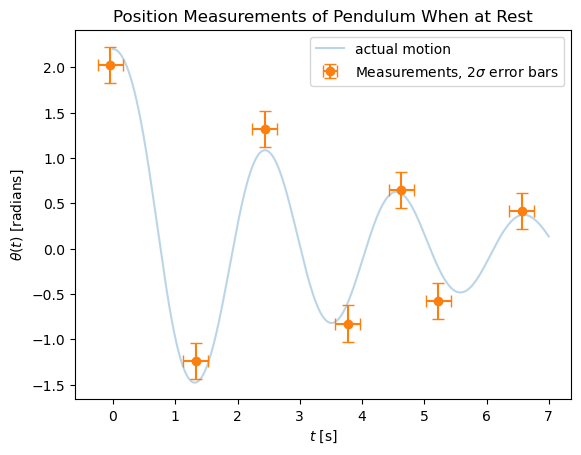

In [24]:
# assume the data is drawn from a damped, unforced oscillator
t_values = np.linspace(0,7,num_timesteps)

theta_measurement_error = 0.2 # 2sigma (95% confidence) error on theta measurements[radians] 
t_measurement_error = 0.2 # 2sigma (95% confidence) error on t measurements [s]

theta, v = integrate(v_update_pendulum_drag, t_values, theta0=large_theta0, gamma=gamma) 

# Could use one of two methods to find the extrema here:
# 1. Extract the data points lower or higher than both their neighbors 

indices_local_extrema = [0] # the initial position should be an extremal value of theta

for i in range(1, len(theta) - 1): # exclude first and last entries
    if ((theta[i-1] < theta[i] > theta[i+1]) or (theta[i-1] > theta[i] < theta[i+1])):
        indices_local_extrema.append(i)


mock_data = theta[indices_local_extrema].copy()
mock_data_times = t_values[indices_local_extrema].copy()

# 2. could also just have found the indices where v is very close to zero, which i wont bother coding up


# Add some errors to make it more realistic
mock_data += np.random.normal(0.0, theta_measurement_error/2, size=len(mock_data))
mock_data_times += np.random.normal(0.0, t_measurement_error/2, size=len(mock_data_times))

plt.plot(t_values, theta, alpha=0.3, label="actual motion")
plt.errorbar(mock_data_times, mock_data, yerr=theta_measurement_error, xerr=t_measurement_error, fmt='o', capsize=4, label=r"Measurements, $2\sigma$ error bars")    
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\theta (t)$ [radians]")
plt.title(r"Position Measurements of Pendulum When at Rest")
plt.legend()                                                            

In the notebook saved on github, note that one of those points (at about 5.5 seconds) was measure way off the true value (recall that the error bars are 95% confidence intervals). This means we got unlucky, and I'm going to leave that set of data static for the rest of this section to see what a bad datapoint can do to your answers when using a naive analysis. If you wish to rerun cells, I will save this particular data to a file that can be re-read as follows:

In [23]:
#np.save("mock_data.npy", mock_data)
#np.save("mock_data_times.npy", mock_data_times) # could save them both in one file easily, but we'll do this for simplicity

mock_data = np.load("mock_data.npy")
mock_data_times = np.load("mock_data_times.npy")

### 5.2 Try to infer $g$ from data

This amounts to determining $\omega = \sqrt{\frac{g}{L}}$ which here means $g = \omega^2$

As a fairly unsophisticated method of determining $g$ would be to assume we know $\gamma$, and try out values of $\omega$ to see what visually matches the data best. This doesnt really give you a scientific result, but it gets you a good intuition for the relevant parameters. Lets say we determine a reasonable value for $\gamma$ in our experiment is 0.45 (which is wrong, in fact we used 0.5 to generate the data, and this will be one of the factors influencing our result).

I'll use an interactive plot with a slider to quickly change the motion I'm testing out. I give a detailed example of an interactive plot with sliders [here](https://gist.github.com/CianMRoche/9099162344019011c13dc37210bd20db). It is easy when there is a nice method for your plot object to update the data, and is slightly more awkward when you must redraw the whole plot every time

**Depending on your jupyter setup youll need a different line at the start of the cell below**

Type "%matplotlib widget" (without quotes) If running in vscode and ensure you have "ipympl" module installed in your python environment

Type "%matplotlib notebook" (without quotes) If running in browser-hosted jupyter notebook

interactive(children=(FloatSlider(value=3.2, description='w', max=6.0, min=0.1, step=0.02), Output()), _dom_cl…

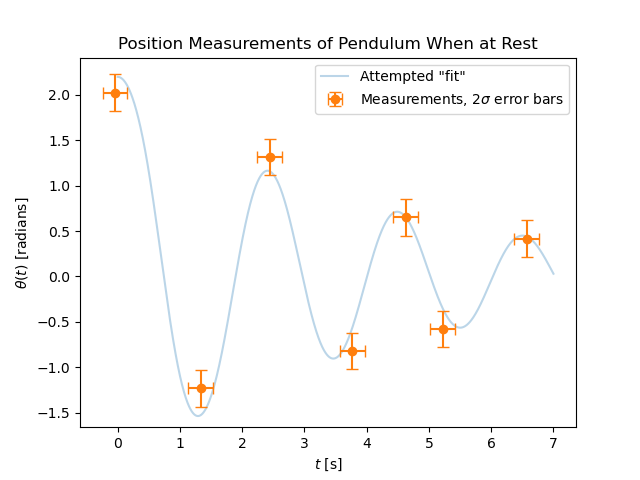

In [25]:
# -- replace the next line if not using vscode --
%matplotlib widget
from ipywidgets import *
import matplotlib.pyplot as plt

gamma_guess = 0.45

# Make plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# need to use the "object-oriented plotting" approach here
line, = ax.plot(t_values, theta, alpha=0.3, label="Attempted \"fit\"") # Make sure you assign the plot object to a variable, 

plt.errorbar(mock_data_times, mock_data, yerr=theta_measurement_error, xerr=t_measurement_error, fmt='o', capsize=4, label=r"Measurements, $2\sigma$ error bars")    

plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\theta (t)$ [radians]")
plt.title(r"Position Measurements of Pendulum When at Rest")
plt.legend()  

# Define a function which updates the plot data when slider changes
def update(w = 3.2):
    theta, v = integrate(v_update_pendulum_drag, t_values, theta0=large_theta0, gamma=gamma_guess, omega=w) 
    line.set_ydata(theta)
    fig.canvas.draw_idle()

# You may need to run plt.show() here depending on your jupyter setup
#plt.show

# Run the interaction
interact(update, w = (0.1, 6.0, 0.02));

My best guess for the above data is about $\omega=3.2$, corresponding to $g = \omega^2 = 10.24$ m/$\text{s}^2$. I came upon this visually, and trying to get all the 95% confidence intervals to encompass the extrema the best I can (recall the really bad data point from earlier, which biases the answer here towards lower periods, and thus higher $\omega$. The fact that most data points are to the right of their respective extrema when we try a best fit is a hint that we have a "bad" data point).

Clearly our guess has pretty large error bars (yet to be quantified), which it seems from the interactive plot are primarily set by the error in time measurements. A slightly incorrect $\gamma$ has relatively little effect on this timescale, and errors in the theta measurement are also relatively inconsequential. That said, over longer timescales, changes in $\gamma$ are quite important (see Sec. 3). Errors in time measurement however play an important role in this determination. Intuition gained. 

In the next iteration of this experiment, I would focus on an experimental method that allows me very high time resolution (though you may decide to do something different entirely) while recording for a longer timescale so $\gamma$ can also be estimated from the data, or focus on reduction of drag OR more accurate theoretical knowledge of drag. A "dirty" estimate of error can be gained by seeing how low and high we can go on $\omega$ before the fit is awful, but such a method only provides an order of magnitude estimate for the "true" errors.

### Adding a second interaction slider

interactive(children=(FloatSlider(value=3.2, description='w', max=6.0, min=0.1, step=0.02), FloatSlider(value=…

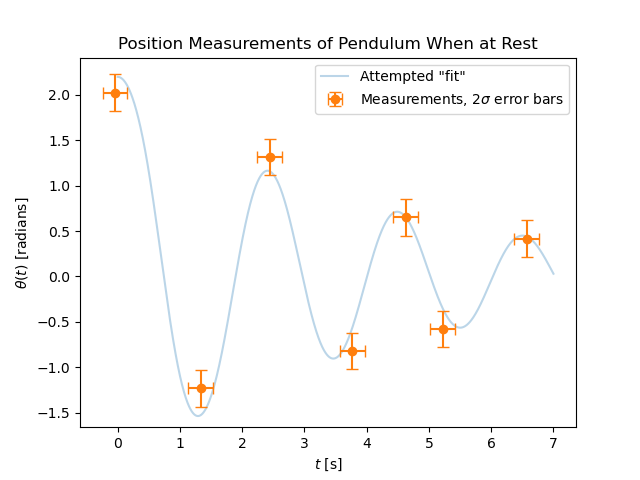

In [26]:
# Make plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# need to use the "object-oriented plotting" approach here
line, = ax.plot(t_values, theta, alpha=0.3, label="Attempted \"fit\"") # Make sure you assign the plot object to a variable, 

plt.errorbar(mock_data_times, mock_data, yerr=theta_measurement_error, xerr=t_measurement_error, fmt='o', capsize=4, label=r"Measurements, $2\sigma$ error bars")    

plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\theta (t)$ [radians]")
plt.title(r"Position Measurements of Pendulum When at Rest")
plt.legend()  

# Define a function which updates the plot data when slider changes
def update(w = 3.2, gamma=0.45):
    theta, v = integrate(v_update_pendulum_drag, t_values, theta0=large_theta0, gamma=gamma, omega=w) 
    line.set_ydata(theta)
    fig.canvas.draw_idle()

# You may need to run plt.show() here depending on your jupyter setup
#plt.show

# Run the interaction
interact(update, w = (0.1, 6.0, 0.02), gamma = (0.1, 3.0, 0.02));

### Working with only timing data

Say we just use a stopwatch to note the times when the bob has zero velocity. That is, the same as the above mock data but we dont bother writing down the angle measurement, then our data would look something like this:

interactive(children=(FloatSlider(value=3.2, description='w', max=6.0, min=0.1, step=0.02), FloatSlider(value=…

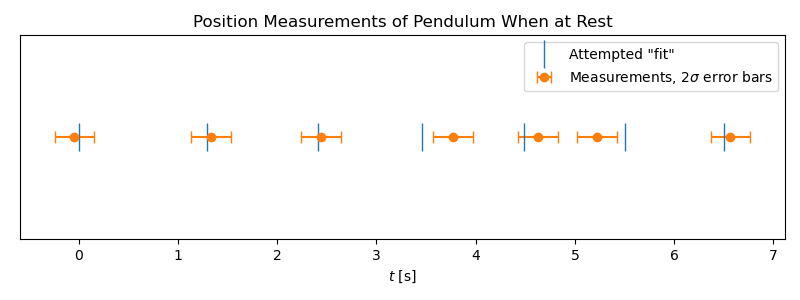

In [58]:
# Make plot
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1, 1, 1)

offset = 0.2

plt.errorbar(mock_data_times, np.zeros_like(mock_data_times), xerr=t_measurement_error, 
            color="C1", fmt='o', capsize=4, label=r"Measurements, $2\sigma$ error bars")    

# need to use the "object-oriented plotting" approach here
line, = ax.plot([], [], '|', alpha=1.0, color='C0', label="Attempted \"fit\"", markersize=20) # Make sure you assign the plot object to a variable, 

plt.xlabel(r"$t$ [s]")
plt.title(r"Position Measurements of Pendulum When at Rest")
plt.yticks([])
#plt.ylim(-0.2,0.4)
plt.legend()  

# Define a function which updates the plot data when slider changes
def update(w = 3.2, gamma=0.45):
    theta, v = integrate(v_update_pendulum_drag, t_values, theta0=large_theta0, gamma=gamma, omega=w) 
    indices_local_extrema = [0] # the initial position should be an extremal value of theta

    # find times when bob is at rest
    for i in range(1, len(theta) - 1): # exclude first and last entries
        if ((theta[i-1] < theta[i] > theta[i+1]) or (theta[i-1] > theta[i] < theta[i+1])):
            indices_local_extrema.append(i)

    mock_data_times = t_values[indices_local_extrema].copy()

    line.set_xdata(mock_data_times)
    line.set_ydata(np.zeros_like(mock_data_times))
    fig.canvas.draw_idle()

plt.tight_layout()
# You may need to run plt.show() here depending on your jupyter setup
#plt.show

# Run the interaction
interact(update, w = (0.1, 6.0, 0.02), gamma = (0.1, 3.0, 0.02));